In [1]:
import wrds
import pandas as pd
import numpy as np
import statsmodels.api as sm
import csv
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


In [2]:
# try:
#     with open('your_file.csv', 'r') as file:
#         problem_permnos = list(csv.reader(file))
# except:
#     print("No file")
#     problem_permnos = []

# DATA COLLECTION

## SNP , RFR & Factors , Trading Days

In [3]:
query_start_date = '2009-01-01'

In [4]:
fama_data = conn.raw_sql(f'''
    SELECT
        date,
        mktrf AS market_factor,  -- Market factor (excess return on the market)
        smb AS size_factor,  -- Size factor (Small Minus Big)
        hml AS value_factor,  -- Value factor (High Minus Low)
        umd AS momentum_factor,  -- Momentum factor
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '{query_start_date}'
''')

fama_data['date'] = pd.to_datetime(fama_data['date'])

fama_data

,date,market_factor,size_factor,value_factor,momentum_factor,daily_rf_rate
0,2009-01-02,0.0311,-0.0127,-0.0044,-0.0428,0.00000
1,2009-01-05,-0.0028,0.0069,-0.0116,-0.0283,0.00000
2,2009-01-06,0.0087,0.0101,0.0088,-0.0503,0.00000
3,2009-01-07,-0.0296,0.0034,-0.0115,0.0182,0.00000
4,2009-01-08,0.0047,0.0072,0.0043,-0.0149,0.00000
...,...,...,...,...,...,...
3980,2024-10-25,-0.0009,-0.0001,-0.0083,-0.0009,0.00017
3981,2024-10-28,0.0038,0.0115,0.0061,0.0034,0.00017
3982,2024-10-29,0.0015,0.0012,-0.0105,0.0058,0.00017
3983,2024-10-30,-0.0033,-0.0008,0.0076,-0.0037,0.00017


In [5]:
sp500_data = conn.raw_sql(f"""
SELECT
    caldt AS date,
    spindx AS snp_prc, -- usdval
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)   
FROM
    crspq.dsp500
WHERE
    caldt >= '{query_start_date}'
ORDER BY
    caldt;
""")

sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,snp_prc,daily_return
0,2009-01-02,931.80,0.031608
1,2009-01-05,927.45,-0.004668
2,2009-01-06,934.70,0.007817
3,2009-01-07,906.65,-0.030010
4,2009-01-08,909.73,0.003397
...,...,...,...
3957,2024-09-24,5732.93,0.002511
3958,2024-09-25,5722.26,-0.001861
3959,2024-09-26,5745.37,0.004039
3960,2024-09-27,5738.17,-0.001253


In [6]:
last_trading_days = conn.raw_sql(f'''
SELECT DISTINCT
    MAX(date) AS last_trade_date
FROM
    crsp.dsf
WHERE
    date >= '{query_start_date}'
GROUP BY DATE_TRUNC('month', date)
ORDER BY last_trade_date
''')

last_trading_days['last_trade_date'] = pd.to_datetime(last_trading_days['last_trade_date'])
last_trading_days['month'] = last_trading_days['last_trade_date'].dt.month
last_trading_days['year'] = last_trading_days['last_trade_date'].dt.year
last_trading_day_mapping = last_trading_days.set_index(['year', 'month'])['last_trade_date'].to_dict()

last_trading_days

,last_trade_date,month,year
0,2009-01-30,1,2009
1,2009-02-27,2,2009
2,2009-03-31,3,2009
3,2009-04-30,4,2009
4,2009-05-29,5,2009
...,...,...,...
175,2023-08-31,8,2023
176,2023-09-29,9,2023
177,2023-10-31,10,2023
178,2023-11-30,11,2023


### SNP & RFR Monthly and Cumulative SNP Returns

In [7]:
# def calculate_cumulative_returns(daily_returns, dates):
#     cumulative_returns = []
#     for i in range(len(dates) - 1):
#         start_date, end_date = dates[i], dates[i + 1]
#         mask = (daily_returns['date'] >= start_date) & (daily_returns['date'] < end_date)
#         returns_in_range = daily_returns.loc[mask, 'daily_rf_rate']
#         if not returns_in_range.empty:
#             num_days = len(returns_in_range)
#             annualized_compounded_rate = np.prod(1 + returns_in_range) - 1
#             cumulative_return = (1 + annualized_compounded_rate) ** (12 / num_days) - 1
#         else:
#             cumulative_return = np.nan
#         cumulative_returns.append({'date': end_date, 'rf_rate': cumulative_return})
#     return pd.DataFrame(cumulative_returns)

# risk_free_data = calculate_cumulative_returns(fama_data, last_trading_days['last_trade_date'])

# risk_free_data

In [8]:
def calculate_cumulative_returns(daily_returns, dates, columns):
    cumulative_returns = []
    for i in range(len(dates) - 1):
        start_date, end_date = dates[i], dates[i + 1]
        mask = (daily_returns['date'] >= start_date) & (daily_returns['date'] < end_date)
        returns_in_range = daily_returns.loc[mask]
        cumulative_row = {'date': end_date}
        for col in columns:
            if col in returns_in_range.columns:
                column_returns = returns_in_range[col]
                if not column_returns.empty:
                    num_days = len(column_returns)
                    annualized_compounded_rate = np.prod(1 + column_returns) - 1
                    cumulative_return = (1 + annualized_compounded_rate) ** (12 / num_days) - 1
                else:
                    cumulative_return = np.nan
            else:
                cumulative_return = np.nan  # Handle missing columns gracefully
            cumulative_row[col] = cumulative_return
        cumulative_returns.append(cumulative_row)
    return pd.DataFrame(cumulative_returns)

columns_to_aggregate = ['market_factor', 'size_factor', 'value_factor', 'momentum_factor', 'daily_rf_rate']
fama_data = calculate_cumulative_returns(fama_data, last_trading_days['last_trade_date'], columns_to_aggregate)

fama_data.rename(columns={'daily_rf_rate':'rf_rate'}, inplace=True)
risk_free_data = fama_data[['date', 'rf_rate']]
factor_data = fama_data[['date', 'market_factor', 'size_factor', 'value_factor', 'momentum_factor']]

risk_free_data

,date,rf_rate
0,2009-02-27,0.000114
1,2009-03-31,0.000120
2,2009-04-30,0.000120
3,2009-05-29,0.000006
4,2009-06-30,0.000000
...,...,...
174,2023-08-31,0.002413
175,2023-09-29,0.002517
176,2023-10-31,0.002523
177,2023-11-30,0.002523


In [9]:
sp500_data = pd.merge(last_trading_days[['last_trade_date']], sp500_data, left_on='last_trade_date', right_on='date', how='left')

sp500_data['snp_return'] = sp500_data['snp_prc'].pct_change()

sp500_data.drop(columns=['last_trade_date', 'daily_return'], axis=1, inplace=True)

sp500_data

,date,snp_prc,snp_return
0,2009-01-30,825.88,NaN
1,2009-02-27,735.09,-0.109931
2,2009-03-31,797.87,0.085405
3,2009-04-30,872.81,0.093925
4,2009-05-29,919.14,0.053081
...,...,...,...
175,2023-08-31,4507.66,-0.017716
176,2023-09-29,4288.05,-0.048719
177,2023-10-31,4193.80,-0.021980
178,2023-11-30,4567.80,0.089179


## Query Company Data

In [10]:
def get_company_financials(gvkey):
    company_fin_data = conn.raw_sql(f'''
    SELECT
        datadate AS date,
        gvkey AS gvkey,
        rdq AS reporting_date, -- Date of which information was reported
        atq AS total_assets,  -- Total Assets
        chq AS cash_holdings,  -- Cash and Short-Term Investments
        dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        ibq AS earnings,  -- Earnings before extraordinary items
        xrdq AS rd_expense,  -- R&D expense
        dvpq AS dividends_paid,  -- Dividends paid
        xintq AS interest_expense  -- Interest expense
    FROM
        comp.fundq
    WHERE
        gvkey = '{gvkey}'
        AND datadate >= '{query_start_date}'  -- Ensure data is after the link start date
    ''')
    
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])
    
    return company_fin_data.fillna(0)

In [11]:
def make_PiT_ffill(company_fin_data, date_column):

    temp = company_fin_data.copy()

    temp['reporting_date'] = pd.to_datetime(temp[date_column]) + pd.Timedelta(days=1)
    temp['month'] = temp['reporting_date'].dt.month
    temp['year'] = temp['reporting_date'].dt.year
    
    temp['EOM_trade_date'] = temp.apply(
        lambda row: last_trading_day_mapping.get((row['year'], row['month'])),
        axis=1
    )
    temp.drop(columns=['date','month','year','reporting_date'], axis=1, inplace=True)
    temp.rename(columns={'EOM_trade_date':'date'}, inplace=True)
    temp = temp[temp.columns[-1:].append(temp.columns[:-1])]
    temp['date'] = pd.to_datetime(temp['date'])

    try:
        start_date = temp['date'].min()
        end_date = temp['date'].max()
        all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
        full_range_df = pd.DataFrame({'date': all_months})
        temp = pd.merge(full_range_df, temp, on='date', how='left')
        temp = temp.ffill()
        return temp
    
    except:
        return pd.DataFrame({"date":[]})

In [12]:
def get_prices(permno):
    company_stock_prcs = conn.raw_sql(f'''
    SELECT
        permno,
        date,
        prc AS stock_price,  -- Raw stock price
        shrout,              -- Shares outstanding
        cfacpr,              -- Cumulative adjustment factor for prices
        cfacshr              -- Cumulative adjustment factor for shares
    FROM
        crsp.dsf
    WHERE
        permno = {permno}
        AND date >= '{query_start_date}'
    ''')

    company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])
    company_stock_prcs['stock_price'] = company_stock_prcs['stock_price'] / company_stock_prcs['cfacpr'] # Adjust stock price for splits and dividends
    company_stock_prcs['adj_shrout'] = company_stock_prcs['shrout'] * company_stock_prcs['cfacshr'] # Adjust shares outstanding for splits
    company_stock_prcs['market_cap'] = company_stock_prcs['stock_price'] * company_stock_prcs['adj_shrout'] # Calculate adjusted market capitalization

    company_stock_prcs = pd.merge(last_trading_days[['last_trade_date']], company_stock_prcs, left_on='last_trade_date', right_on='date', how='left')
    company_stock_prcs['stock_return'] = company_stock_prcs['stock_price'].pct_change()

    return company_stock_prcs[['date', 'permno', 'stock_price', 'market_cap', 'stock_return']]

In [13]:
def get_comp_data(permno, gvkey):

    company_fin_data = make_PiT_ffill(get_company_financials(gvkey), 'reporting_date')
    company_stock_prcs = get_prices(permno)
    
    company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='right').ffill()

    return company

# Calculate Cash Hedged Returns

In [14]:
def calculate_b_it(company):
    data = company.copy()
    data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
    data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
    
    # Y VALUES
    data['r_minus_R'] = data['stock_return'] - data['rf_rate']

    # REGRESSION VARIABLES
    data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
    data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
    data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
    data['gamma_8'] = data['leverage']
    data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
    data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
    data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']
    
    data = data.dropna()
    
    y = data['r_minus_R']
    X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    #print(model.summary())
    
    data['marginal_cash_value'] = (
        model.params.iloc[0] +
        (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
        (model.params.iloc[11] * data['leverage'])
    )
    
    data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']
    
    company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return

In [15]:
def calculate_e_it(company):
    company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

In [16]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

In [17]:
def calculate_returns(company):
    company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
    company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
    
    calculate_b_it(company)
    calculate_e_it(company)
    
    company['cash_hedged_return'] = winsorize(company['cash_hedged_return'])

In [18]:
def calculate_rolling_beta(stock_return, market_return, window = 65):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

# Data Aggregation

In [19]:
# problematic_permnos = set()

def main(id_table):

    agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
        'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
        'interest_expense', 'stock_price', 'stock_return', 'market_cap',
        'cash_share_weight', 'cash_holdings_t_minus_1',
        'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

    # Create a mapping from permno to comnam
    comnam_mapping = id_table.set_index('permno')['comnam'].to_dict()

    permnos = id_table['permno'].to_list()
    gvkeys = id_table['gvkey'].to_list()

    for i in range(len(permnos)):

        company = get_comp_data(permnos[i], gvkeys[i])

        if company.empty:
            continue

        try:
            company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')
            
            company = pd.merge(company, sp500_data, on='date', how='inner')
            company = pd.merge(company, risk_free_data, on='date', how='inner')
            calculate_returns(company)
            
            # company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'])
            # company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'])
            
            if not agg_fin_data.empty:
                agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
            else:
                agg_fin_data = company
        
        except:
            print("Problematic Company: ", company['comnam'][0])
            #problem_permnos.append(company.iloc[0]['permno'])
            continue 
        
    agg_fin_data = agg_fin_data.sort_values(by=['comnam', 'date']).reset_index(drop=True)

    agg_fin_data = agg_fin_data[['date', 'comnam', 'gvkey', 'permno', 'stock_price', 'stock_return', 'b_it' ,'cash_hedged_return', 'snp_prc', 'snp_return', 'rf_rate']] #, 'company_beta', 'cash_hedged_beta']].dropna()

    return agg_fin_data.reset_index(drop=True)

# Portfolio Selection

## Choosing Companies

### Get Unique Identifiers


In [20]:
def get_gvkey(permno_list):
    permno_tuple = tuple(permno_list)
    query = f"""
    SELECT DISTINCT lpermno AS permno, gvkey
    FROM crsp.ccmxpf_linktable
    WHERE lpermno IN {permno_tuple};
    """
    link_table = conn.raw_sql(query)
    link_table = link_table.drop_duplicates(subset=['permno', 'gvkey'])
    return link_table['gvkey']

### Handpicked Portfolio Used for Testing

In [21]:
# query = '''
# SELECT
#     DISTINCT ON (a.permno)
#     a.permno,
#     a.comnam
# FROM
#     crsp.stocknames a
# WHERE
#     a.comnam ilike '%%alphabet%%' AND a.cusip like '02079K30' OR
#     a.comnam ilike '%%amazon%%' OR
#     a.comnam ilike '%%apple inc%%' OR
#     a.comnam ilike '%%meta platforms%%' OR
#     a.comnam ilike '%%microsoft%%' OR
#     a.comnam ilike '%%nvidia%%' OR
#     a.comnam ilike '%%tesla inc%%' OR
#     a.comnam ilike '%%netflix%%' OR
#     a.comnam ilike '%%walmart%%' OR
#     a.comnam ilike '%%pfizer%%'
# ;
# '''

### NASDAQ Universe Portfolio

In [22]:
query = """
SELECT *
FROM (
    SELECT DISTINCT ON (a.permno) 
        a.permno, 
        a.permco, 
        a.cusip, 
        a.comnam, 
        a.end_date, 
        a.st_date,
        a.siccd
    FROM crsp.stocknames a
    WHERE a.hexcd IN (3) and a.end_date = '2023-12-29' and a.st_date <= '2000-01-01' and (a.siccd < 6000 or a.siccd > 6799)
    ORDER BY a.permno, a.end_date DESC
) subquery
ORDER BY end_date DESC;

"""

### Run Query (Selected Universe)

In [23]:
ids = conn.raw_sql(query)
permnos = ids['permno'].to_list()
#permnos = [x for x in permnos if x not in problem_permnos]
gvkeys = get_gvkey(permnos)
#ids['permno'] = permnos
ids['gvkey'] = gvkeys

ids

,permno,permco,cusip,comnam,end_date,st_date,siccd,gvkey
0,10026,7976,46603210,J & J SNACK FOODS CORP,2023-12-29,1986-02-04,2050,063005
1,10032,7980,72913210,PLEXUS CORP,2023-12-29,1986-02-05,3670,028749
2,10044,7992,77467X10,ROCKY MOUNTAIN CHOCOLATE FAC INC,2023-12-29,1986-02-11,2060,001602
3,10066,6331,35518410,ABM COMPUTER SYS,2023-12-29,1983-08-25,3573,012181
4,10107,8048,59491810,MICROSOFT CORP,2023-12-29,1986-03-13,7370,026922
...,...,...,...,...,...,...,...,...
609,88779,7343,44934S20,HOWTEK INC,2023-12-29,1984-12-13,3555,061418
610,89456,7459,50216C10,L S I LIGHTING SYS INC,2023-12-29,1985-03-12,3648,015414
611,89858,34920,72650310,PLAINS ALL AMERN PIPELINE L P,2023-12-29,1998-11-18,4619,036153
612,89915,7301,58058910,MCGRATH RENTCORP,2023-12-29,1984-11-13,5510,006416


## Running the data collection function

In [24]:
universe_data = main(ids) # input is any table with [permno, gvkey, comnam]

universe_data

Problematic Company:  BEL FUSE INC
Problematic Company:  SAFEGUARD INDS INC
Problematic Company:  CROWN CRAFTS INC
Problematic Company:  PAYCHEX INC
Problematic Company:  VERTEX PHARMACEUTICALS INC
Problematic Company:  N T N COMMUNICATIONS INC
Problematic Company:  CHEESECAKE FACTORY INC
Problematic Company:  VOICE POWERED TECH INTL INC
Problematic Company:  GROW BIZ INTERNATIONAL INC
Problematic Company:  ITRON INC
Problematic Company:  HAWAIIAN AIRLINES INC NEW
Problematic Company:  ECHOSTAR COMMUNICATIONS CORP NEW
Problematic Company:  PROGRAMMERS PARADISE INC
Problematic Company:  JEWETT CAMERON TRADING LTD
Problematic Company:  SILVER STANDARD RESOURCES INC
Problematic Company:  WILLIS LEASE FINANCE CORP
Problematic Company:  PC CONNECTION INC
Problematic Company:  PHONE COM INC


,date,comnam,gvkey,permno,stock_price,stock_return,b_it,cash_hedged_return,snp_prc,snp_return,rf_rate
0,2009-02-27,1 800 FLOWERS COM INC,NaN,87162,1.33,-0.470120,NaN,NaN,735.09,-0.109931,0.000114
1,2009-03-31,1 800 FLOWERS COM INC,NaN,87162,2.07,0.556391,NaN,NaN,797.87,0.085405,0.000120
2,2009-04-30,1 800 FLOWERS COM INC,060902,87162,2.92,0.410628,NaN,NaN,872.81,0.093925,0.000120
3,2009-05-29,1 800 FLOWERS COM INC,060902,87162,2.33,-0.202055,NaN,NaN,919.14,0.053081,0.000006
4,2009-06-30,1 800 FLOWERS COM INC,060902,87162,1.92,-0.175966,0.212104,-0.307461,919.32,0.000196,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
106743,2023-08-31,ZENECA GROUP PLC,190355,79363,67.82,-0.054114,2.197183,-0.364483,4507.66,-0.017716,0.002413
106744,2023-09-29,ZENECA GROUP PLC,190355,79363,67.72,-0.001474,0.001479,-0.001882,4288.05,-0.048719,0.002517
106745,2023-10-31,ZENECA GROUP PLC,190355,79363,63.23,-0.066302,0.071010,-0.085233,4193.80,-0.021980,0.002523
106746,2023-11-30,ZENECA GROUP PLC,190355,79363,64.59,0.021509,0.313015,-0.033917,4567.80,0.089179,0.002523


In [25]:
# try:
#     with open('problem_permnos.csv', 'a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(set(problem_permnos))
# except:
#     print("Failed to update problem_permnos.csv file.")

# Backtesting

Using the cash_hedged_returns as a signal of whether or not to take a position based on 
the previous X (X = lookback_period) months of cash_hedged_return performance. Works.

In [26]:
def backtest_portfolio(inp, lookback_months, signal='b_it', return_column='stock_return'):
    """
    Backtests a portfolio strategy based on Point-in-Time data for monthly data.

    Parameters:
    - inp: DataFrame with Point-in-Time financial data.
        - Must contain columns: 'date', 'comnam', signal, return_column.
    - lookback_months: Number of months to look back to calculate positions and weights.
    - signal: The column representing the performance signal for each company.
    - return_column: The column representing stock returns for the following month.

    Returns:
    - DataFrame with portfolio returns for each available trading month.
    - DataFrame with portfolio weights for each company and date.
    """

    # Create a copy of the input data
    data = inp.copy()

    # Ensure data is sorted by company and date
    data = data.sort_values(['comnam', 'date']).reset_index(drop=True)

    # Group data by company
    grouped = data.groupby('comnam')

    # Initialize lists for portfolio returns and weights
    portfolio_returns = []
    portfolio_weights = []

    # Unique dates (assume these are the last trading days of each month)
    unique_dates = sorted(data['date'].unique())

    for current_date in unique_dates:
        portfolio = []

        for company, group in grouped:
            # Get company data up to the current date
            company_data = group[group['date'] < current_date]
            lookback_data = company_data.tail(lookback_months)

            # Skip if there's insufficient lookback data
            if len(lookback_data) < lookback_months:
                continue

            # Calculate the signal's performance over the lookback period
            signal_performance = lookback_data[signal].mean()

            # Only include companies with a positive signal
            if signal_performance > 0:
                # Get the return for the following month
                next_month_return = group.loc[group['date'] == current_date, return_column]
                if not next_month_return.empty:
                    portfolio.append({
                        'company': company,
                        'weight': signal_performance,
                        'monthly_return': next_month_return.values[0]
                    })

        # Normalize weights for the portfolio
        if portfolio:
            portfolio_df = pd.DataFrame(portfolio)
            total_weight = portfolio_df['weight'].sum()
            portfolio_df['normalized_weight'] = portfolio_df['weight'] / total_weight

            # Calculate the portfolio return for the current month
            portfolio_return = (portfolio_df['normalized_weight'] * portfolio_df['monthly_return']).sum()

            # Store weights for the current portfolio
            for _, row in portfolio_df.iterrows():
                portfolio_weights.append({
                    'date': current_date,
                    'company': row['company'],
                    'weight': row['normalized_weight'],
                    'return': row['monthly_return']
                })
        else:
            portfolio_return = 0

        # Append the portfolio return for the current date
        portfolio_returns.append({'date': current_date, f'{signal}_portfolio_return': portfolio_return})

    # Convert portfolio returns and weights to DataFrames
    portfolio_returns_df = pd.DataFrame(portfolio_returns)
    portfolio_weights_df = pd.DataFrame(portfolio_weights)

    return portfolio_returns_df, portfolio_weights_df

## Optimization of lookback period

In [27]:
from scipy.optimize import minimize

signal = 'b_it'

training_data = universe_data.loc[(universe_data['date'] >= '2010-01-01') & (universe_data['date'] < '2015-01-01')]

# Objective function to maximize Sharpe Ratio
def objective(lookback_months, training_data):
    lookback_months = int(lookback_months)  # Ensure it's an integer
    if lookback_months < 1:
        return -np.inf  # Penalize invalid lookback values
    
    # Run the backtesting function with the given lookback_months
    portfolio_returns_df, details = backtest_portfolio(training_data, lookback_months)
    
    # Extract portfolio returns
    portfolio_returns = portfolio_returns_df[f'{signal}_portfolio_return']
    
    # Avoid invalid calculations
    if portfolio_returns.empty or portfolio_returns.std() == 0:
        return -np.inf  # Penalize for lack of variance or empty returns
    
    # Compute Sharpe Ratio (assuming risk-free rate r_f = 0)
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
    
    # Return negative Sharpe Ratio because we want to maximize it
    return -sharpe_ratio

# Bounds for lookback months
bounds = [(1, 12)]  # Example: 1 to 12 months

# Optimize lookback_months
result = minimize(objective, x0=3, args=(training_data,), bounds=bounds, method='Powell')

optimal_lookback_months = int(result.x)
print(f"{signal} - optimal Lookback Months: {optimal_lookback_months}")

b_it - optimal Lookback Months: 11


In [28]:
testing_data = universe_data[universe_data['date'] >= '2015-01-01']

temp_1, positions = backtest_portfolio(testing_data, signal='b_it', lookback_months=optimal_lookback_months)
# temp_2 = backtest_portfolio(universe_data, signal='cash_hedged_return', lookback_months=7)

portfolio = pd.merge(temp_1, testing_data[testing_data['permno'] == testing_data.iloc[0]['permno']], on='date', how='right')

# portfolio = pd.merge(portfolio, temp_2, on='date', how='left')

portfolio['log_temp_return'] = np.log1p(portfolio['b_it_portfolio_return'])
portfolio['b_it_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

portfolio['rf_cum_return'] = (1 + portfolio['rf_rate']).cumprod() - 1
portfolio['log_temp_return'] = np.log1p(portfolio['snp_return'])
portfolio['snp_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

portfolio = portfolio[['date', 'b_it_portfolio_return', 'b_it_portfolio_cum_return', 'snp_return', 'snp_cum_return', 'rf_rate', 'rf_cum_return']]

portfolio

,date,b_it_portfolio_return,b_it_portfolio_cum_return,snp_return,snp_cum_return,rf_rate,rf_cum_return
0,2015-01-30,0.0,0.00000,-0.031041,-0.031041,0.000000,0.000000
1,2015-02-27,0.0,0.00000,0.054893,0.022148,0.000000,0.000000
2,2015-03-31,0.0,0.00000,-0.017396,0.004366,0.000000,0.000000
3,2015-04-30,0.0,0.00000,0.008521,0.012924,0.000000,0.000000
4,2015-05-29,0.0,0.00000,0.010491,0.023551,0.000000,0.000000
...,...,...,...,...,...,...,...
103,2023-08-31,0.0,-0.97765,-0.017716,1.189354,0.002413,0.057757
104,2023-09-29,0.0,-0.97765,-0.048719,1.082690,0.002517,0.060419
105,2023-10-31,0.0,-0.97765,-0.021980,1.036913,0.002523,0.063094
106,2023-11-30,0.0,-0.97765,0.089179,1.218563,0.002523,0.065777


In [29]:
positions

,date,company,weight,return
0,2015-10-30,G WILLI FOOD INTL LTD,0.604886,-0.042316
1,2015-10-30,VIACOM INC,0.395114,-2.126837
2,2015-11-30,G WILLI FOOD INTL LTD,0.254660,-0.192093
3,2015-11-30,MICROSTRATEGY INC,0.370127,0.007555
4,2015-11-30,VIACOM INC,0.375212,-2.088052
...,...,...,...,...
33325,2023-12-29,WISCONSIN PHARMACAL CO INC,0.000000,-0.246152
33326,2023-12-29,XEROX CORP,0.000000,0.310222
33327,2023-12-29,XOMA CORP,0.000000,0.246631
33328,2023-12-29,ZEBRA TECHNOLOGIES CORP,0.000000,0.153388


## Performance Analysis

### Monthly Returns

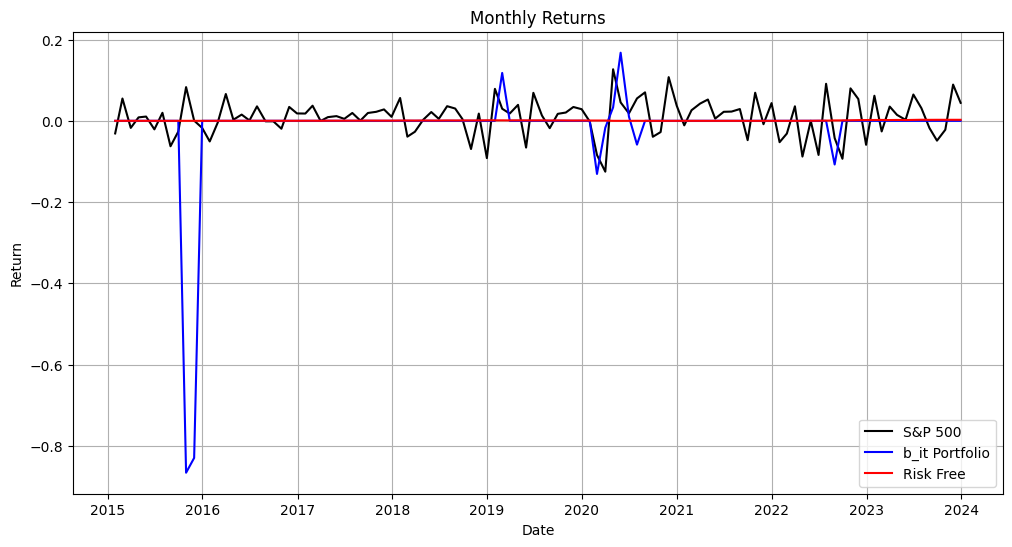

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['date'], portfolio['snp_return'], label='S&P 500', color='black')
plt.plot(portfolio['date'], portfolio['b_it_portfolio_return'], label='b_it Portfolio', color='blue')
# plt.plot(portfolio['date'], portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green')
plt.plot(portfolio['date'], portfolio['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

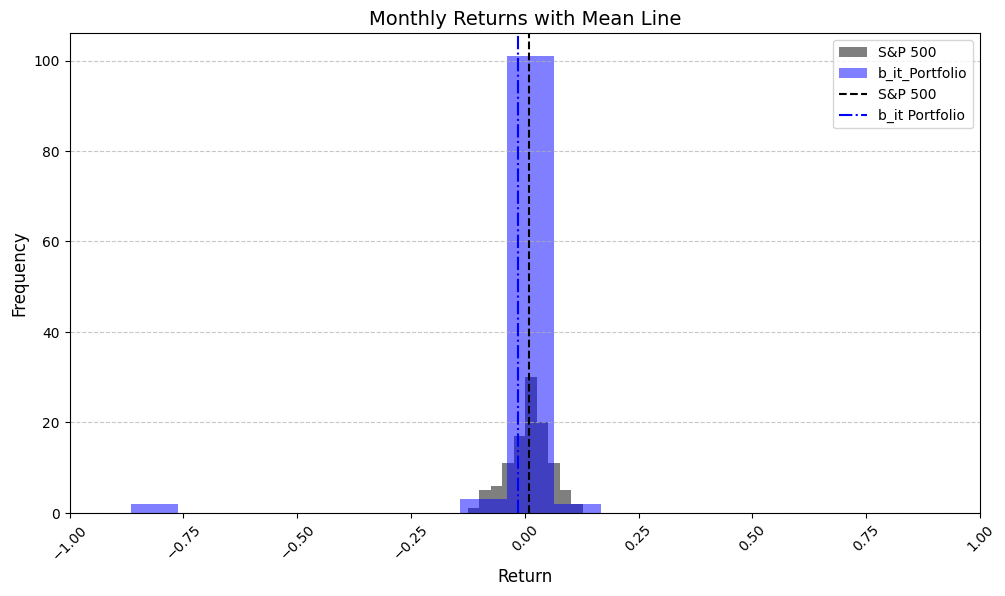

In [31]:
plt.figure(figsize=(10, 6))

plt.hist(portfolio['snp_return'], label='S&P 500', color='black', alpha=0.5)
plt.hist(portfolio['b_it_portfolio_return'], label='b_it_Portfolio', color='blue', alpha=0.5)
# plt.hist(portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green', alpha=0.5)

plt.axvline(portfolio["snp_return"].mean(), color="black", linestyle="--", label=f"S&P 500")
plt.axvline(portfolio["b_it_portfolio_return"].mean(), color="blue", linestyle="-.", label=f'b_it Portfolio')
# plt.axvline(portfolio["cash_hedged_return_portfolio_return"].mean(), color="green", linestyle="-.", label=f'CHR Portfolio')

plt.title("Monthly Returns with Mean Line", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.xlim(-1, 1)
plt.show()

### Cumulative Returns

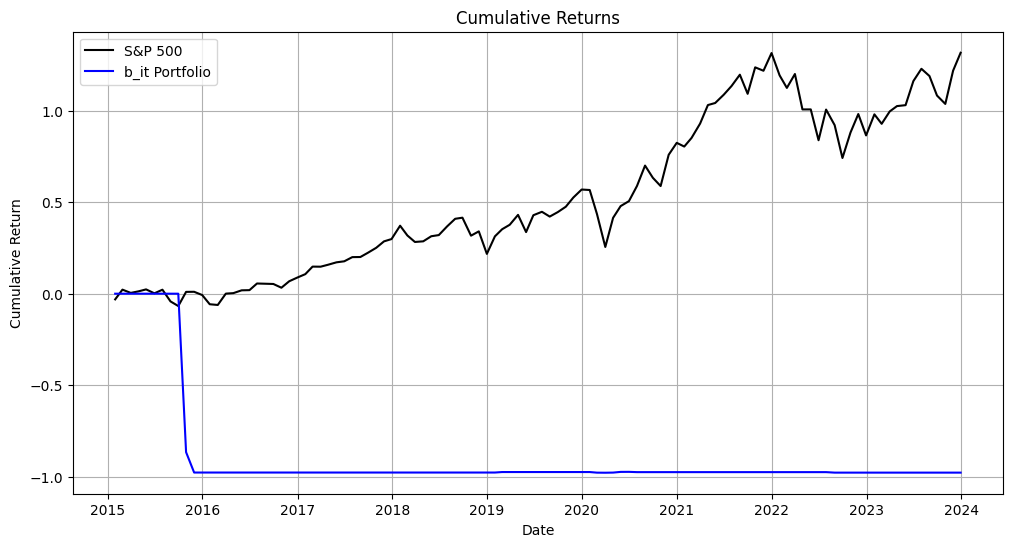

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['date'], portfolio['snp_cum_return'], label='S&P 500', color='black')
plt.plot(portfolio['date'], portfolio['b_it_portfolio_cum_return'], label='b_it Portfolio', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

### SHARPE - (over the portfolio period) 

In [33]:
def sharpe(df, ret):
    excess_ret = df[f"{ret}"] - df["rf_rate"]
    average_excess_return = excess_ret.mean()
    std_excess_return = excess_ret.std()
    return (average_excess_return / std_excess_return) * np.sqrt(12)

print("ANNUALISED:")

pd.DataFrame(
    [
        ["SNP500" , '{0:.4f}'.format(sharpe(portfolio, 'snp_return')), (1 + portfolio['snp_return'].mean()) ** 12 - 1, (1 + (portfolio['snp_return'].std()**2)) ** 12 - 1],
        ["b_it Portfolio" , '{0:.4f}'.format(sharpe(portfolio, 'b_it_portfolio_return')), (1 + portfolio['b_it_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['b_it_portfolio_return'].std()**2)) ** 12 - 1]
        # ["CHR Portfolio" , '{0:.4f}'.format(sharpe('cash_hedged_return_portfolio_return')), (1 + portfolio['cash_hedged_return_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['cash_hedged_return_portfolio_return'].std()**2)) ** 12 - 1],
    ],
    columns=['Asset', 'SHARPE', 'Mean Return', 'Volatility']
)

ANNUALISED:


,Asset,SHARPE,Mean Return,Volatility
0,SNP500,0.6255,0.111421,0.025203
1,b_it Portfolio,-0.4754,-0.171523,0.180178


## Alpha

In [34]:
factor_data

,date,market_factor,size_factor,value_factor,momentum_factor
0,2009-02-27,-0.066011,-0.010848,-0.039968,0.029445
1,2009-03-31,0.029247,0.011839,0.003750,-0.062946
2,2009-04-30,0.064904,0.025542,0.045556,-0.158249
3,2009-05-29,0.022204,-0.019892,0.000994,-0.091221
4,2009-06-30,0.013972,0.015974,-0.013878,0.017973
...,...,...,...,...,...
174,2023-08-31,-0.010695,-0.010387,-0.007605,0.013066
175,2023-09-29,-0.030506,-0.016581,0.008486,0.014936
176,2023-10-31,-0.022445,-0.022309,0.003176,0.006941
177,2023-11-30,0.050881,0.003275,0.008529,0.005148


In [35]:
data = pd.merge(factor_data, portfolio[['date', 'b_it_portfolio_return']], on='date', how='inner')

y = data['b_it_portfolio_return']
X = data[['market_factor', 'size_factor', 'value_factor', 'momentum_factor']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("ALPHA GENERATED: ", model.params.iloc[0])

ALPHA GENERATED:  -0.013431817321745258
